In [1]:
import torch
from torch import nn
import torchvision.transforms as T
from presnet import PResNet
from hybrid_encoder import HybridEncoder
from rtdetrv2_decoder import RTDETRTransformerv2
from rtdetr_postprocessor import RTDETRPostProcessor
from rtdetrv2_criterion import RTDETRCriterionv2
from matcher import HungarianMatcher
import cv2
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F 

In [2]:
# Setup Feature Extractor
presnet = PResNet(depth= 18,
                  variant = 'd',
                  freeze_at = -1,
                  return_idx = [1, 2, 3],
                  num_stages = 4,
                  freeze_norm = False,
                  pretrained = True, 
                  act="leaky_relu",)

Load PResNet18 state_dict


In [3]:
encoder = HybridEncoder(  in_channels = [128, 256, 512],
                          feat_strides = [8, 16, 32],
                          # intra
                          hidden_dim = 256,
                          use_encoder_idx = [2],
                          num_encoder_layers = 2,
                          nhead = 8,
                          dim_feedforward = 1024,
                          dropout = 0.,
                          enc_act = 'gelu' ,
                          # cross
                          expansion = 0.5,
                          depth_mult = 1,
                          act = 'silu')

In [4]:
decoder = RTDETRTransformerv2(feat_channels = [256, 256, 256],
                              feat_strides = [8, 16, 32],
                              hidden_dim = 256,
                              num_levels = 3,
                              num_layers = 3,
                              num_queries = 300,
                              num_denoising = 200,
                              label_noise_ratio = 0.5,
                              box_noise_scale = 1.0, # 1.0 0.4
                              eval_idx = -1,
                              # NEW
                              num_points = [4, 4, 4], # [3,3,3] [2,2,2]
                              cross_attn_method = 'default', # default, discrete
                              query_select_method = 'agnostic', # default, agnostic 
                              num_classes=1,
                              activation="relu",
                              dropout=0
                              )

In [5]:
postprocessor = RTDETRPostProcessor()

In [6]:
losses = ['vfl', 'boxes']
weight_dict={'cost_class': 2, 'cost_bbox':5, 'cost_giou':2}
matcher = HungarianMatcher(use_focal_loss=False, weight_dict = weight_dict)
weight_dict = {'loss_vfl': 1, 'loss_bbox': 5, 'loss_giou': 2}
criterion = RTDETRCriterionv2(losses=losses, weight_dict=weight_dict, matcher=matcher)

In [7]:
class Model(nn.Module):
    def __init__(self, ) -> None:
        super().__init__()
        self.backbone = presnet
        self.encoder = encoder
        self.decoder = decoder
        self.postprocessor = postprocessor
        
    def forward(self, images, targets = None):
        features = self.backbone(images)
        features = self.encoder(features)
        out = self.decoder(features, targets)
        return out


In [8]:
detr = Model()
checkpoint = torch.load('detr_checkpoint_desk.pth', map_location=torch.device('cpu'))  # Use map_location if loading on CPU

detr.load_state_dict(checkpoint["model_state_dict"])
detr.eval()


/tmp/ipykernel_1662046/3883158284.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('detr_checkpoint_desk.pth', map_location=torch.device('cpu'))  

Model(
  (backbone): PResNet(
    (conv1): Sequential(
      (conv1_1): ConvNormLayer(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (conv1_2): ConvNormLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (conv1_3): ConvNormLayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (res_layers): ModuleList(
      (0): Blocks(
        (blocks): Mod

In [9]:
# Loading the dataset
from dataset import PersonDataset
from torch.utils.data import random_split, DataLoader

root_dir = '/media/enrique/Extreme SSD/person'
sequence_list = [f'person-{i}' for i in range(1, 21)]
sequence_list = ["person-9"]
dataset = PersonDataset(root_dir=root_dir, sequence_list=sequence_list, img_transform_size=(640, 640), template_transform_size=(256, 256), max_num_templates=10, max_detections = 300)

batch_size = 1
# Optionally, create DataLoader objects for the training and validation sets
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
data_iter = iter(data_loader)
data_sample = next(data_iter)

In [11]:
print(data_sample['img'].shape)
print(data_sample['target_bounding_box'].shape)
print(data_sample['bounding_boxes'].shape)
print(data_sample['templates'].shape)
print(data_sample['num_boxes'])
print(data_sample['num_templates'])


torch.Size([1, 3, 640, 640])
torch.Size([1, 4])
torch.Size([1, 300, 4])
torch.Size([1, 10, 3, 256, 256])
tensor([7])
tensor([9])


In [12]:
test_img = data_sample['img']

In [13]:
output = detr(test_img)

In [18]:
logits = output["pred_logits"]
boxes = output["pred_boxes"]
print(logits.shape)

torch.Size([1, 300, 1])


In [15]:
prob = F.sigmoid(logits)

In [43]:
def visualize_batch_data_sample(output, data_sample, threshold=0.3):
    # Extract the batch of images, bounding boxes, and original dimensions
    imgs = data_sample["img"]  # Batch of images (B, C, H, W)
    bounding_boxes = output["pred_boxes"]  # Batch of bounding boxes (B, N, 4)
    pred_logits = output["pred_logits"]  # Batch of predicted logits (B, N, 1)
    orig_dims = data_sample["orig_dim"]  # Batch of original image dimensions (B, 2)

    batch_size = imgs.shape[0]  # Get the batch size

    for i in range(batch_size):

        # Extract the image, bounding boxes, and original dimensions for the i-th sample
        img = imgs[i].permute(1, 2, 0).detach().cpu().numpy()  # Convert from PyTorch tensor to NumPy and swap channels (H, W, C)
        img = (img * 255).astype("uint8").copy()  # Denormalize image if it's normalized to [0, 1]
        orig_h, orig_w = orig_dims  # Get the original height and width of the i-th image

        # Resize the image to the original dimensions
        img = cv2.resize(img, (orig_w.item(), orig_h.item()))

        # Loop over each bounding box for the i-th image
        for j in range(bounding_boxes[i].shape[0]):

            prob = F.sigmoid(pred_logits[i, j, 0]).item()
            # Check if the probability is greater than the threshold
            if prob >= threshold:

                # Bounding box format: (x_center, y_center, width, height) with unit scaling
                x_center, y_center, w, h = bounding_boxes[i, j]

                # Rescale the bounding box to the original image dimensions
                x_center = x_center * orig_w
                y_center = y_center * orig_h
                w = w * orig_w
                h = h * orig_h

                # Calculate the top-left and bottom-right corners of the bounding box
                x1 = int(x_center - w / 2)
                y1 = int(y_center - h / 2)
                x2 = int(x_center + w / 2)
                y2 = int(y_center + h / 2)

                # Draw the bounding box on the image using OpenCV (red color, thickness=2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # Display the probability next to the bounding box
                label = f"{prob:.2f}"
                cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        
        
        # Display the image with bounding boxes using Matplotlib
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV format) to RGB for Matplotlib
        plt.axis("off")  # Hide axes
        plt.show()


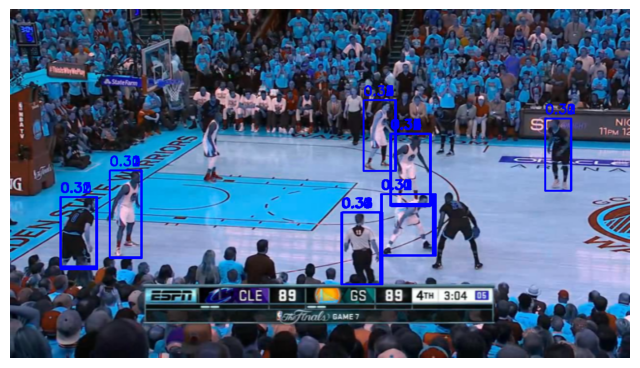

In [44]:
visualize_batch_data_sample(output, data_sample)